In [1]:
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
#正态分布的概率密度函数。x（自变量） mu（均值）和 cov（协方差）
def normfun(x,mu,cov):
    pdf=stats.multivariate_normal(mean=mu, cov=cov).pdf(x) #loc是均值 cov是协方差
    return pdf

标准正态分布图像

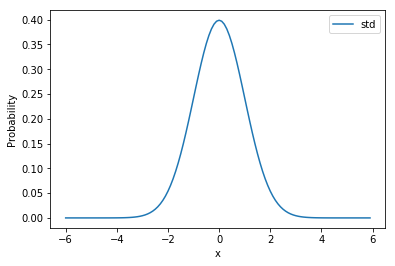

In [3]:
# 设定 x 轴前两个数字是 X 轴的开始和结束，第三个数字表示步长，或者区间的间隔长度
x_range = np.arange(-6,+6,0.1) #画图时只取从-6到+6步长为0.1共120个点来画
y_std = normfun(x_range, 0, 1)
plt.plot(x_range,y_std,label='std')
plt.legend()
plt.xlabel('x')
plt.ylabel('Probability')
#输出
plt.show()

In [4]:
#概率密度混合
def mix(dict_f):
    K=dict_f['K']
    GMM_mixture=np.zeros(120)
    for i in range(K):
        y = normfun(x_range,dict_f['means'][i],dict_f['covs'][i])
        GMM_mixture=GMM_mixture+dict_f['pi'][i]*y
    return GMM_mixture

#采样函数，dict_f为采样参数的字典，N为采样个数
def sample(dict_f,N):
    K=dict_f['K']
    N0=int(N*dict_f['pi'][0])
    X=stats.multivariate_normal(mean=dict_f['means'][0],cov=dict_f['covs'][0]).rvs(N0)
    for k in range(1,K):
        Nk=int(N*dict_f['pi'][k])
        Xk=stats.multivariate_normal(mean=dict_f['means'][k],cov=dict_f['covs'][k]).rvs(Nk)
        X=np.append(X,Xk,axis=0)
    return X

任务1：三个一维高斯混合求解：
选定两个高斯，分别为：
y1:mean1=-2 cov1=0.25
y2:mean2=2 cov2=1
y3:mean3=0 cov3=4
混合系数为0.2\0.6\0.2

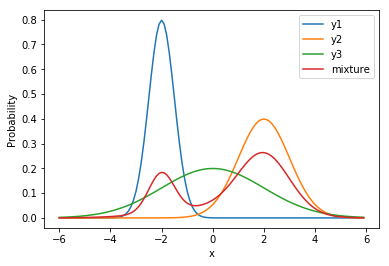

In [5]:
# 设定 x 轴前两个数字是 X 轴的开始和结束，第三个数字表示步长，或者区间的间隔长度

dict_f={'K':3,'pi':[0.2,0.6,0.2],'means':[-2,2,0],'covs':[0.25,1,4]}

x = np.arange(-6,6,0.1) 
y1 = normfun(x,dict_f['means'][0],dict_f['covs'][0])
y2 = normfun(x,dict_f['means'][1],dict_f['covs'][1])
y3 = normfun(x,dict_f['means'][2],dict_f['covs'][2])

mixture = mix(dict_f)

plt.plot(x_range,y1,label='y1')
plt.plot(x_range,y2,label='y2')
plt.plot(x_range,y3,label='y3')
plt.plot(x_range,mixture,label='mixture')

plt.legend()
plt.xlabel('x')
plt.ylabel('Probability')
#输出'
plt.show()

从以上高斯中采样出实际数据点

(100000,)


/home/mis/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


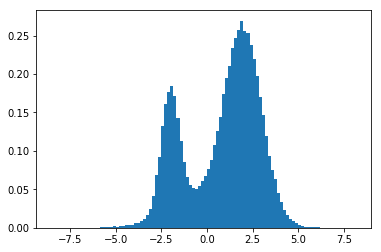

In [6]:
dict_f={'K':3,'pi':[0.2,0.6,0.2],'means':[-2,2,0],'covs':[0.25,1,4]}
X=sample(dict_f,100000)
print(X.shape)
plt.hist(X,bins=100,normed=True)
#输出'
plt.show()


定义GMM模型，输入为采样数据X，预估高斯个数K，迭代次数，输出为K个高斯分别的系数mean和std，以及它们之间的混合系数pi

In [7]:
def GMM_model(X,K,iternum):
    epsilon=0.00001
    if len(X.shape)==1:
        dim=1
    else:
        dim=X.shape[1] #dim是多维高斯分布的维数
    pi=np.random.rand(K)
    pi=pi/np.sum(pi) #pi是K个高斯分布的混合比例
    means=np.random.rand(K,dim)
    covs=np.zeros((K,dim,dim))
    for k in range(K):
        covs[k]=np.identity(dim)      
    print('随机初始参数：')
    print('pi:',pi)
    print('means:',means)
    print('covs:',covs)
    
    #初始化隐变量r
    N=X.shape[0]  #N为总数据量
    r=np.zeros(shape=(N,K),dtype='float64')
    
    for it in range(iternum):
        #迭代求解
        #求r
        for k in range(0,K):
            r[:,k]=pi[k]*normfun(X,means[k],covs[k])
        rsum=np.sum(r,axis=1,dtype='float64')
        #print(rsum)
        for i in range(N):
            r[i,:]=(r[i,:]+epsilon)/(rsum[i]+epsilon*K)
        #print(r)

        #求Nk
        Nk=np.sum(r,axis=0)
        #print('Nk',Nk)

        #求means
        for k in range(0,K):
            means[k]=(1/Nk[k])*np.matmul(r[:,k],X)
        #print('means',means)
        
        #求stds
        for k in range(0,K):
            if dim==1:
                covs[k]=(1/Nk[k])*np.matmul(np.transpose(X-means[k]),r[:,k]*(X-means[k]))
            else:
                covs[k]=(1/Nk[k])*np.matmul(np.transpose(X-means[k]),r[:,k,np.newaxis]*(X-means[k]))
        #print('covs',covs)

        #求pi
        pi=Nk/N
        #print('pi',pi)
        
        if it%10==0:
            print('iter:',it)
            
    return {'K':K,'pi':pi,'means':means,'covs':covs}

In [8]:
res=GMM_model(X,3,100)

随机初始参数：
pi: [ 0.25664498  0.26193212  0.4814229 ]
means: [[ 0.53184799]
 [ 0.25368369]
 [ 0.83942492]]
covs: [[[ 1.]]

 [[ 1.]]

 [[ 1.]]]
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90


In [9]:
print(res)

{'K': 3, 'pi': array([ 0.14174932,  0.22134755,  0.63690313]), 'means': array([[-0.01763732],
       [-1.96817264],
       [ 1.94963597]]), 'covs': array([[[ 4.16524828]],

       [[ 0.32659715]],

       [[ 1.08358666]]])}


根据算出的高斯重新画图，并与原混合高斯对比

/home/mis/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


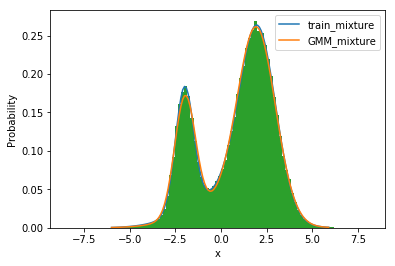

In [10]:
x = np.arange(-6,6,0.1) 

GMM_mixture=mix(res)
plt.plot(x_range,mixture,label='train_mixture')
plt.plot(x_range,GMM_mixture,label='GMM_mixture')
plt.hist(X,bins=100,normed=True)

plt.legend()
plt.xlabel('x')
plt.ylabel('Probability')
#输出'
plt.show()

任务2：2维高斯分布

In [11]:
mean1 = (-3, 3)
cov1 = [[1, 0], [0, 1]]

mean2 = (0, 0)
cov2 = [[1, 0], [0, 1]]

mean3 = (-5, -5)
cov3 = [[1, 0], [0, 1]]

dict_f={'K':3,'pi':[0.2,0.6,0.2],'means':[mean1,mean2,mean3],'covs':[cov1,cov2,cov3]}
X=sample(dict_f,10000)
print(X.shape)

(10000, 2)


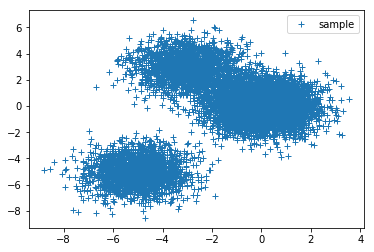

In [12]:
plt.plot(X[:,0],X[:,1],'+',label='sample')
plt.legend()
plt.show()

In [13]:
res=GMM_model(X,3,100)

随机初始参数：
pi: [ 0.06812672  0.24339099  0.68848229]
means: [[ 0.95119697  0.63316001]
 [ 0.99154873  0.4499019 ]
 [ 0.58578275  0.4328653 ]]
covs: [[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90


In [14]:
print('smaple:',dict_f)
print('GMM_model:',res)

smaple: {'K': 3, 'pi': [0.2, 0.6, 0.2], 'means': [(-3, 3), (0, 0), (-5, -5)], 'covs': [[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]]}
GMM_model: {'K': 3, 'pi': array([ 0.20799766,  0.20004464,  0.59195769]), 'means': array([[-2.93272507,  2.91748565],
       [-4.97257329, -5.01719295],
       [ 0.01465087, -0.01135093]]), 'covs': array([[[ 1.10065681, -0.06066518],
        [-0.06066518,  1.26249983]],

       [[ 1.10712647,  0.09861675],
        [ 0.09861675,  1.17548377]],

       [[ 0.98942291,  0.02757154],
        [ 0.02757154,  0.99442342]]])}


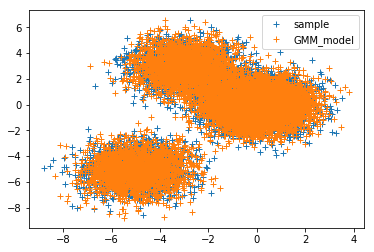

In [15]:
Y=sample(res,10000)
plt.plot(X[:,0],X[:,1],'+',label='sample')
plt.plot(Y[:,0],Y[:,1],'+',label='GMM_model')
plt.legend()
plt.show()

五维以上高斯分布

In [16]:
mean1 = (2, 2, -2, -3)
cov1 = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

mean2 = (0, 0, 0, 0)
cov2 = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

mean3 = (2, 2, -2, 3)
cov3 = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

dict_f={'K':3,'pi':[0.1,0.6,0.3],'means':[mean1,mean2,mean3],'covs':[cov1,cov2,cov3]}
X=sample(dict_f,10000)
print(X.shape)
print(X)

(10000, 4)
[[ 2.07186855  2.37890015 -1.79077243 -2.84434114]
 [ 2.48831748  0.88637768 -3.66048728 -2.96464072]
 [ 1.11986869  0.97281456 -1.07433997 -3.15204603]
 ..., 
 [ 0.58358118  3.4494306  -0.40287353  3.2777489 ]
 [ 0.70195098  1.72855571 -1.90481676  1.28088359]
 [ 2.81547962  0.47435967 -0.97800697  2.09115803]]


In [17]:
res=GMM_model(X,3,500)

随机初始参数：
pi: [ 0.47516382  0.40946565  0.11537053]
means: [[ 0.72869213  0.60259006  0.49548084  0.99376318]
 [ 0.1698736   0.27823247  0.64317347  0.87904733]
 [ 0.93010926  0.5251853   0.25560876  0.10967528]]
covs: [[[ 1.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  1.]]

 [[ 1.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  1.]]

 [[ 1.  0.  0.  0.]
  [ 0.  1.  0.  0.]
  [ 0.  0.  1.  0.]
  [ 0.  0.  0.  1.]]]
iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90
iter: 100
iter: 110
iter: 120
iter: 130
iter: 140
iter: 150
iter: 160
iter: 170
iter: 180
iter: 190
iter: 200
iter: 210
iter: 220
iter: 230
iter: 240
iter: 250
iter: 260
iter: 270
iter: 280
iter: 290
iter: 300
iter: 310
iter: 320
iter: 330
iter: 340
iter: 350
iter: 360
iter: 370
iter: 380
iter: 390
iter: 400
iter: 410
iter: 420
iter: 430
iter: 440
iter: 450
iter: 460
iter: 470
iter: 480
iter: 490


In [18]:
print('smaple:',dict_f)
print('GMM_model:',res)

smaple: {'K': 3, 'pi': [0.1, 0.6, 0.3], 'means': [(2, 2, -2, -3), (0, 0, 0, 0), (2, 2, -2, 3)], 'covs': [[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]]}
GMM_model: {'K': 3, 'pi': array([ 0.30898074,  0.55398443,  0.13703483]), 'means': array([[  1.93477713e+00,   1.87102853e+00,  -1.90228417e+00,
          2.75147339e+00],
       [ -1.33848039e-02,  -2.32596033e-03,  -5.76302797e-03,
          1.44602424e-02],
       [  1.53051129e+00,   1.53564178e+00,  -1.54194538e+00,
         -1.82137517e+00]]), 'covs': array([[[ 1.13212855,  0.15896476, -0.14732172,  0.25500331],
        [ 0.15896476,  1.13725659, -0.16412977,  0.24827104],
        [-0.14732172, -0.16412977,  1.14652976, -0.2521401 ],
        [ 0.25500331,  0.24827104, -0.2521401 ,  2.04568862]],

       [[ 1.03813825,  0.04745187, -0.09191798,  0.02979778],
        [ 0.04745187,  1.05730091, -0.06518301, 